# Classification of pulser stars using different machine learning techniques

## a) Importing the data for pulsar candidates:
HTRU2 is a data set which describes a sample of pulsar candidates collected during the High Time Resolution Universe Survey.

Pulsars are a rare type of Neutron star that produce radio emission detectable here on Earth. They are of considerable scientific interest as probes of space-time, the inter-stellar medium, and states of matter .

As pulsars rotate, their emission beam sweeps across the sky, and when this crosses our line of sight, produces a detectable pattern of broadband radio emission. As pulsars
rotate rapidly, this pattern repeats periodically. Thus pulsar search involves looking for periodic radio signals with large radio telescopes.

Each pulsar produces a slightly different emission pattern, which varies slightly with each rotation . Thus a potential signal detection known as a 'candidate', is averaged over many rotations of the pulsar, as determined by the length of an observation. In the absence of additional info, each candidate could potentially describe a real pulsar. However in practice almost all detections are caused by radio frequency interference (RFI) and noise, making legitimate signals hard to find.

Machine learning tools are now being used to automatically label pulsar candidates to facilitate rapid analysis. Classification systems in particular are being widely adopted,
which treat the candidate data sets as binary classification problems. Here the legitimate pulsar examples are a minority positive class, and spurious examples the majority negative class.

The data set shared here contains a total of 17 898 examples, where 16 259 are spurious examples caused by RFI/noise, and 1 639 are real pulsar examples. These examples have all been checked by human annotators.

Each row lists the variables first, and the class label is the final entry. The class labels used are 0 (negative) and 1 (positive).

### Attribute Information:
Each candidate is described by 8 continuous variables, and a single class variable. The first four are simple statistics obtained from the integrated pulse profile (folded profile). This is an array of continuous variables that describe a longitude-resolved version of the signal that has been averaged in both time and frequency . The remaining four variables are similarly obtained from the DM-SNR curve . These are summarised below:

1. Mean of the integrated profile.
2. Standard deviation of the integrated profile.
3. Excess kurtosis of the integrated profile.
4. Skewness of the integrated profile.
5. Mean of the DM-SNR curve.
6. Standard deviation of the DM-SNR curve.
7. Excess kurtosis of the DM-SNR curve.
8. Skewness of the DM-SNR curve.
9. Class


Source: https://archive.ics.uci.edu/ml/datasets/HTRU2

R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, Fifty Years of Pulsar Candidate Selection: From simple filters to a new principled real-time classification approach, Monthly Notices of the Royal Astronomical Society 459 (1), 1104-1123, DOI: 10.1093/mnras/stw656

In [1]:
# Importing libraries

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import scikitplot as skplt
from IPython.display import Image 
from pydot import graph_from_dot_data
import pydotplus
import os

Here we define paths for the data and resulting files, we import the file with the data, we read it using Pandas and we visualize the first 5 lines of the loaded data.

In [2]:
# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

# Open data file
infile = open(data_path("pulsar_stars.csv"),'r')

# Read the experimental data with Pandas
from IPython.display import display
data = pd.read_csv(infile, skiprows=1,
                   names = ('mean_profile','std_profile','kurtosis_profile','skewness_profile',
                            'mean_dmsnr','std_dmsnr','kurtosis_dmsnr','skewness_dmsnr','target_class'))
data = pd.DataFrame(data)
# Preview the first 5 lines of the loaded data 
data.head()

,mean_profile,std_profile,kurtosis_profile,skewness_profile,mean_dmsnr,std_dmsnr,kurtosis_dmsnr,skewness_dmsnr,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


Here we select our features and targets, plot the correlation matrix of the features, create separate data sets with pulsar and non pulsar stars, plot the datapoint for some selected features and finally we divide our data in training and test sets.

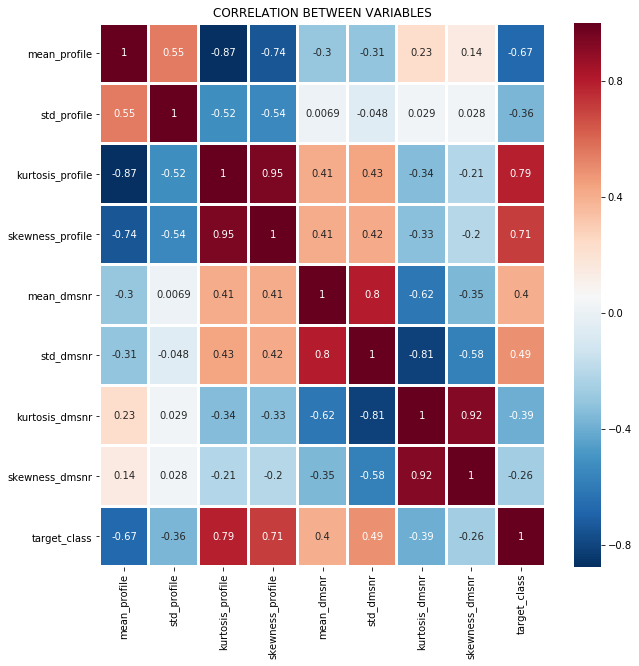

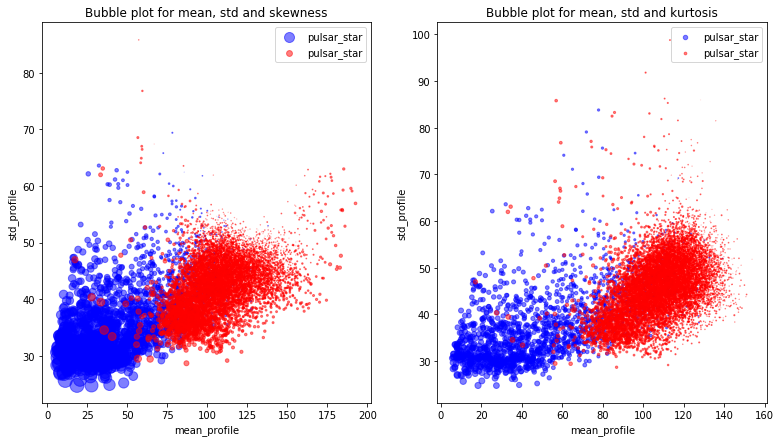

In [11]:
# Features and targets
X = data.loc[:, data.columns != 'target_class'].values
y = data.loc[:, data.columns == 'target_class'].values
y=np.reshape(y, len(y))     # This column-vector was changed to a 1D array to avoid problems with future calculations

# Get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdBu_r", linewidth=2,edgecolor="k")
#plt.tight_layout()
plt.title("CORRELATION BETWEEN VARIABLES")

# Create data sets separating pulsar (st) and non pulsar (nst) stars
st=data[data["target_class"] == 1]
nst=data[data["target_class"] == 0]

# Plot data points as function of mean profile (x-axis), standard deviation of profile (y-axis) 
#and skewness of profile (dot size)
plt.figure(figsize=(13,7))
plt.subplot(121)
plt.scatter(st["mean_profile"],st["std_profile"],alpha=.5,
            s=st["skewness_profile"]*3,linewidths=1,color="b",label="pulsar_star")
plt.scatter(nst["mean_profile"],nst["std_profile"],alpha=.5,
            s=nst["skewness_profile"]*3,linewidths=1,color="r",label="pulsar_star")
plt.legend(loc="best")
plt.xlabel("mean_profile")
plt.ylabel("std_profile")
plt.title("Bubble plot for mean, std and skewness")

# Plot data points as function of mean profile (x-axis), standard deviation of profile (y-axis) 
#and excess kurtosis of profile (dot size)
plt.subplot(122)
plt.scatter(st["mean_profile"],st["std_profile"],alpha=.5,
            s=st["kurtosis_profile"]*5,linewidths=1,color="b",label="pulsar_star")
plt.scatter(nst["mean_profile"],nst["std_profile"],alpha=.5,
            s=nst["kurtosis_profile"]*5,linewidths=1,color="r",label="pulsar_star")
plt.legend(loc="best")
plt.xlabel("mean_profile")
plt.ylabel("std_profile")
plt.title("Bubble plot for mean, std and kurtosis")
plt.show()

# Divide data in training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## b) Classification through different methods:

Now, we can use different methods to classify our data. We train the model, check the accuracy of the training with the test data and check the Confusion Matrix, which tells us the ratio of the correctly predicted data and the "confused" data. The methods to be used are Logistic Regression, Decision Tree Classifier, Decision Trees with Bagging Classifier and Random Forests.

### b.1) Logistic Regression:
We perform the classification of the data using Logistic Regression with the default optimization algorithm L-BFGS-B (Software for Large-scale Bound-constrained Optimization).

Train set accuracy with Logistic Regression: 0.978
Test set accuracy with Logistic Regression: 0.982


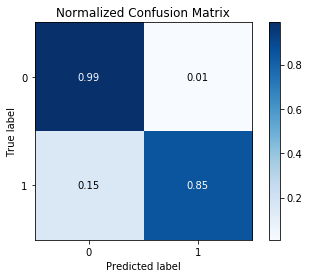

[ 2.36314811e-02 -2.00704735e-02  6.05560810e+00 -5.11211943e-01
 -3.27504610e-02  6.24836034e-02  8.73778697e-02 -4.75014932e-03]


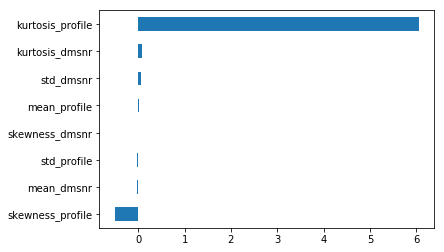

In [4]:
# Logistic Regression
logreg = LogisticRegression(solver='lbfgs',max_iter=200)   # Training of the model
# Accuracu of the trained 
logreg.fit(X_train, y_train)   # Training of the model
# Accuracy of the trained model
print("Train set accuracy with Logistic Regression: {:.3f}".format(logreg.score(X_train,y_train)))
print("Test set accuracy with Logistic Regression: {:.3f}".format(logreg.score(X_test,y_test)))

# Prediction of the test datas set using the trained model and resulting confusion matrix
y_pred_logreg = logreg.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred_logreg, normalize=True)
plt.show()

# Get importances of the features and plot for better visualization
coef = logreg.coef_
coef=np.reshape(coef, 8)
print(coef)
feat_importances = pd.Series(coef, index=data.loc[:, data.columns != 'target_class'].columns)
feat_importances.nsmallest(8).plot(kind='barh')
plt.show()

### b.2) Decision Trees:

We perform the classification of the data using Decision Trees with different maximum depths and plot the resulting decision tree graph. Then we apply the bagging method to see if the results 

Bagging is a general-purpose procedure for reducing the variance of a statistical learning method.

(CART algorithm, gini index)

Train set accuracy with Decision Tree with max depth 2: 0.977
Test set accuracy with Decision Tree with max depth 2: 0.980


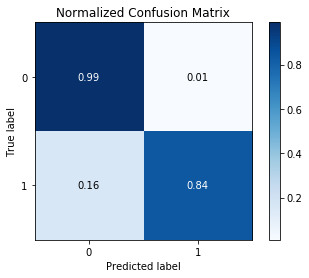

[0. 0. 1. 0. 0. 0. 0. 0.]
(8,)


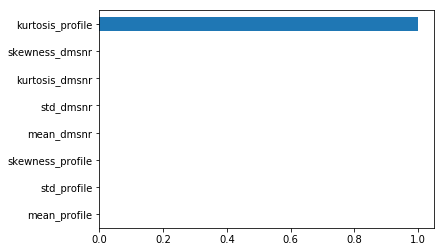

In [5]:
# Classification tree with max depth 2
tree2_clf = DecisionTreeClassifier(criterion='gini', max_depth=2)   # Selection of parameters for the model
tree2_clf.fit(X_train, y_train)   # Training of the model
# Accuracy of the trained model
rint("Train set accuracy with Decision Tree with max depth 2: {:.3f}".format(tree2_clf.score(X_train, y_train)))
print("Test set accuracy with Decision Tree with max depth 2: {:.3f}".format(tree2_clf.score(X_test,y_test)))

# Transfer the resulting decision tree into a graph
export_graphviz(
    tree2_clf,
    out_file="DataFiles/pulsars_tree2.dot",
    class_names='target_class', # the target names.
    feature_names=('mean_profile','std_profile','kurtosis_profile','skewness_profile',
                'mean_dmsnr','std_dmsnr','kurtosis_dmsnr','skewness_dmsnr'), # the feature names.
    rounded=True,
    filled=True
)
cmd = 'dot -Tpng DataFiles/pulsars_tree2.dot -o Results/FigureFiles/pulsars_tree2.png'
os.system(cmd)

# Prediction of the test datas set using the trained model and resulting confusion matrix
y_pred_tree2 = tree2_clf.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred_tree2, normalize=True)
plt.show()

# Get importances of the features and plot for better visualization
print(tree2_clf.feature_importances_)
feat_importances_tree2 = pd.Series(tree2_clf.feature_importances_, index=data.loc[:, data.columns != 'target_class'].columns)
feat_importances_tree2.nsmallest(8).plot(kind='barh')
plt.show()

Train set accuracy with Decision Tree with max depth 5: 0.983
Test set accuracy with Decision Tree with max depth 5: 0.979


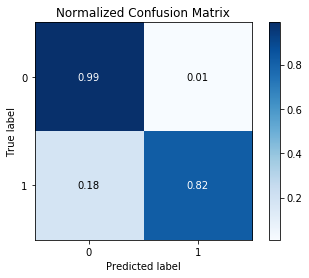

[0.00734056 0.00531027 0.93193118 0.00342549 0.00457032 0.03692115
 0.00913366 0.00136737]


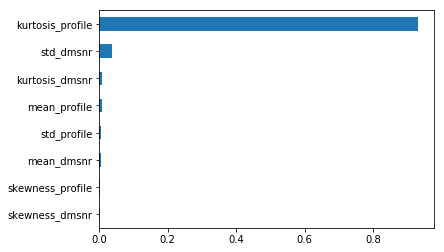

In [6]:
# Classification tree with max depth 5
tree5_clf = DecisionTreeClassifier(criterion='gini', max_depth=5)   # Selection of parameters for the model
tree5_clf.fit(X_train, y_train)   # Training of the model
# Accuracy of the trained model
print("Train set accuracy with Decision Tree with max depth 5: {:.3f}".format(tree5_clf.score(X_train, y_train)))
print("Test set accuracy with Decision Tree with max depth 5: {:.3f}".format(tree5_clf.score(X_test,y_test)))

# Transfer the resulting decision tree into a graph
export_graphviz(
    tree5_clf,
    out_file="DataFiles/pulsars_tree5.dot",
    class_names='target_class', # the target names.
    feature_names=('mean_profile','std_profile','kurtosis_profile','skewness_profile',
                'mean_dmsnr','std_dmsnr','kurtosis_dmsnr','skewness_dmsnr'), # the feature names.
    rounded=True,
    filled=True
)
cmd = 'dot -Tpng DataFiles/pulsars_tree5.dot -o Results/FigureFiles/pulsars_tree5.png'
os.system(cmd)

# Prediction of the test datas set using the trained model and resulting confusion matrix
y_pred_tree5 = tree5_clf.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred_tree5, normalize=True)
plt.show()

# Get importances of the features and plot for better visualization
print(tree5_clf.feature_importances_)
feat_importances_tree5 = pd.Series(tree5_clf.feature_importances_, index=data.loc[:, data.columns != 'target_class'].columns)
feat_importances_tree5.nsmallest(8).plot(kind='barh')
plt.show()

Train set accuracy with Decision Tree with max depth none: 1.000
Test set accuracy with Decision Tree with max depth none: 0.967


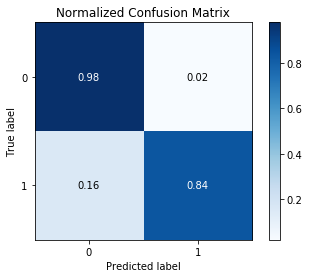

[0.02978669 0.03244935 0.79852568 0.023933   0.01721171 0.05495243
 0.02708653 0.0160546 ]


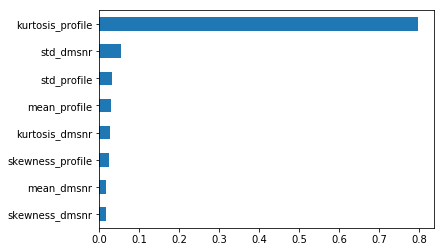

In [7]:
# Classification tree with max depth none
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=None)   # Selection of parameters for the model
tree_clf.fit(X_train, y_train)   # Training of the model
# Accuracy of the trained model
print("Train set accuracy with Decision Tree with max depth none: {:.3f}".format(tree_clf.score(X_train, y_train)))
print("Test set accuracy with Decision Tree with max depth none: {:.3f}".format(tree_clf.score(X_test,y_test)))

# Transfer the resulting decision tree into a graph
export_graphviz(
    tree_clf,
    out_file="DataFiles/pulsars_tree.dot",
    class_names='target_class', # the target names.
    feature_names=('mean_profile','std_profile','kurtosis_profile','skewness_profile',
                'mean_dmsnr','std_dmsnr','kurtosis_dmsnr','skewness_dmsnr'), # the feature names.
    rounded=True,
    filled=True
)
cmd = 'dot -Tpng DataFiles/pulsars_tree.dot -o Results/FigureFiles/pulsars_tree.png'
os.system(cmd)

# Prediction of the test datas set using the trained model and resulting confusion matrix
y_pred_tree = tree_clf.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred_tree, normalize=True)
plt.show()

# Get importances of the features and plot for better visualization
print(tree_clf.feature_importances_)
feat_importances_tree = pd.Series(tree_clf.feature_importances_, index=data.loc[:, data.columns != 'target_class'].columns)
feat_importances_tree.nsmallest(8).plot(kind='barh')
plt.show()

Train set accuracy with Decision Tree and Bagging: 0.977
Test set accuracy with Decision Tree and Bagging: 0.979


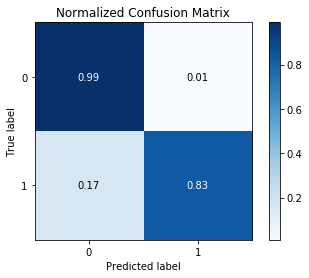

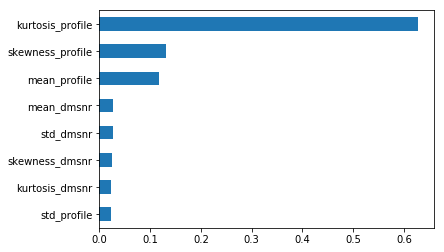

In [8]:
# Classification with Decision Tree with bagging
bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=500,
                            max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)   # Selection of parameters for the model
bag_clf.fit(X_train, y_train)   # Training of the model
# Accuracy of the trained model
print("Train set accuracy with Decision Tree and Bagging: {:.3f}".format(bag_clf.score(X_train, y_train)))
print("Test set accuracy with Decision Tree and Bagging: {:.3f}".format(bag_clf.score(X_test, y_test)))

# Prediction of the test datas set using the trained model and resulting confusion matrix
y_pred_bag = bag_clf.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred_bag, normalize=True)
plt.show()

# Get importances of the features and plot for better visualization
# Since Bagging Classifier doesn't have a feature importances attribute, we need to get the averages of the
#importances from each of the ensemble trees.
feature_importances_bag = np.mean([tree.feature_importances_ for tree in bag_clf.estimators_], axis=0)
feat_importances_bag = pd.Series(feature_importances_bag, index=data.loc[:, data.columns != 'target_class'].columns)
feat_importances_bag.nsmallest(8).plot(kind='barh')
plt.show()

### b.3) Random Forest:


Train set accuracy with Random Forests: 1.000
Test set accuracy with Random Forests: 0.980


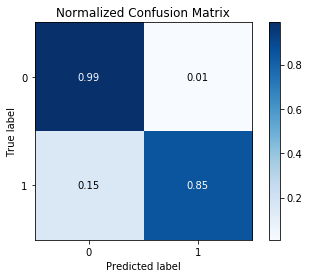

[0.16703412 0.04903173 0.30711027 0.19830289 0.07600525 0.09430757
 0.05598715 0.05222102]


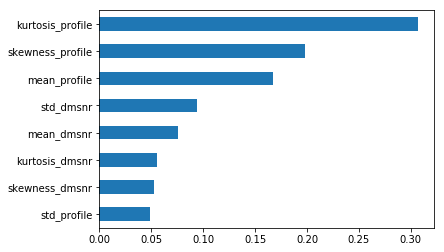

In [9]:
# Data set not specificied
#Instantiate the model with 500 trees and entropy as splitting criteria
Random_Forest_model = RandomForestClassifier(n_estimators=500,criterion="entropy")   # Selection of parameters for the model
Random_Forest_model.fit(X_train, y_train)   # Training of the model

# Accuracy of the trained model
print("Train set accuracy with Random Forests: {:.3f}".format(Random_Forest_model.score(X_train,y_train)))
print("Test set accuracy with Random Forests: {:.3f}".format(Random_Forest_model.score(X_test,y_test)))

# Prediction of the test datas set using the trained model and resulting confusion matrix
y_pred_randfor = Random_Forest_model.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred_randfor, normalize=True)
plt.show()

# Get importances of the features and plot for better visualization
print(Random_Forest_model.feature_importances_)
feat_importances_randfor = pd.Series(Random_Forest_model.feature_importances_, index=data.loc[:, data.columns != 'target_class'].columns)
feat_importances_randfor.nsmallest(8).plot(kind='barh')
plt.show()

In [ ]:
#Cross validation
#accuracy = cross_validate(Random_Forest_model,X_test,y_test,cv=10)['test_score']
#print(accuracy)